In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import timeit
import bz2
import datetime
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

Since we're doing analysis with Natural Language Processing (NLP), we automatically download all packages from nltk and spaCy in the cell below.

In [5]:
!python ./src/load_models_data.py

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Load Data

## Quotes

### Generate a quote sample

First of all, to be able to make a initial analysis of the data, we will work with a subset of the quotes from 2015-2020. 

We put all `quotes-XXXX.json.bz2` in a folder `/data/Quotebank` and, in the cell below, we go through all the quotes and select about 5% of them, and output the result to a file `quotes-sample.json.bz2` in the `data` folder.

In [ ]:
!python ./src/sampling_data.py

After running the previous cell (which we only need to do 1 time), we can load the dataset from the file. We'll do it by chunks so we can pre-process it all.

In [2]:
data_folder = './data/'
data_file = 'quotes-sample.json.bz2'
data_path = data_folder + data_file
chunk_size = 1e4

# Load by chunks
#f = bz2.open(data_path, "rb")
#data=pd.read_json(f, lines=True, chunksize=chunk_size)


## Speaker Attributes

### Pre-processing

Before pre-processing the data, we're gonna need information about each of the speakers (for now, the gender only).

We put the provided `speaker_attributes.parquet` in the `data` folder, and read it. The problem with this file is: everything is given in QID's, instead of actual descriptions/words, so we want to take care of that.

In [ ]:
# Load parquet file
speaker_attributes = pd.read_parquet(data_folder + 'speaker_attributes.parquet')

To convert the QIDs to words, we'll use the other provided dataset `wikidata_labels_descriptions_quotebank.csv.bz2`. This, however, will not be enough for all the speakers, so we need to also use the `wikidata` and `wikipedia` packages.

For now, let's just put this dataset in the `data` folder and load it.

In [ ]:
# Read labels
df_qid_labels = pd.read_csv(data_folder + "wikidata_labels_descriptions_quotebank.csv.bz2", compression='bz2', index_col='QID')

Now, we'll define a function that, for each array of QIDs [Q1,Q2,...] returns the corresponding labels [label1,label2,...].

It works by doing the following:
 - Checking if QID exists in `wikidata_labels_descriptions_quotebank.csv.bz2`. If yes, use that label.
 - If not, check in Wikidata for that QID (which is much slower). If it exists there, use that label.
 - Else, this means the Wikidata page for this QID doesn't exist, so the label is `None`.


In [ ]:
#Function: convert qids to labels
import wikipedia
from wikidata.client import Client
client= Client()

def qid_to_labels(qids, print_errors = False):
  """ Converts [qid1,qid2,...] to [label1,label2,...]"""

  if qids is None:
    return None

  if qids is not None:
      
    labels = []
    for i in range(len(qids)):

      # Try to load qid from csv
      try:
        label = df_qid_labels.loc[qids[i]]['Label']

      except:
        try:
          # csv didn't have the qid, go to wikidata package
          if print_errors: print(f"Error loading {qids[i]} from csv. Wikidata package will be used.")

          entity = client.get(qids[i], load=True)
          entity_df = pd.DataFrame.from_dict(entity.data)
          label = entity_df['labels']['en']['value']

        except:
          # Error 404: Page not found
          if print_error: print("Page not found. Skipping label.")
          label = None

      if len(qids) == 1:
        return label

      # Append to array
      labels.append(label)
      
    return labels

We can now apply this function to every array of QIDs, in all the columns that have them. 

For a faster search of the QIDs, we'll set this 'id' as the index. We'll also drop speaker whose gender is `None`, since they won't contribute to our analyses.


In [ ]:
# Create new columns with labels from QIDs in speaker_attributes into labels
qid_columns = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']

for column in qid_columns:
  speaker_attributes[column+"_label"] = speaker_attributes[column].apply(lambda x: qid_to_labels(x))

# Set 'id' as index, drop rows with 'None' gender
speaker_attributes = speaker_attributes.set_index('id').dropna(subset=['gender'])

Finally, we can save this Dataframe to a `.parquet` file again, so it saves the variables as they are, and not as strings (like in `.csv`).

In [ ]:
# Save to parquet
speaker_attributes.to_parquet(data_folder + "speaker_attributes_processed.parquet")

Now, we can read the `.parquet` of the processed speaker data, which will be used for the pre-processing of the quotes.

In [32]:
speaker_file = 'speaker_attributes_processed.parquet'
speaker_path = data_folder + speaker_file

start = timeit.default_timer()
speaker_attributes = pd.read_parquet(speaker_path)

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Time: 66.3s


In [7]:
speaker_attributes.head(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,...,type,religion,nationality_label,gender_label,ethnic_group_label,occupation_label,party_label,academic_degree_label,candidacy_label,religion_label
id,,,,,,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,...,item,[Q682443],"[Great Britain, United States of America]",male,None,"[politician, military officer, farmer, cartogr...",[independent politician],None,"[1792 United States presidential election, 178...",[Episcopal Church]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,...,item,None,[United Kingdom],male,[White British],"[playwright, screenwriter, novelist, children'...",None,None,None,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,...,item,None,[Belgium],male,None,"[writer, lawyer, librarian, information scient...",None,None,None,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,...,item,"[Q329646, Q682443, Q33203]",[United States of America],male,None,"[politician, motivational speaker, autobiograp...",[Republican Party],None,"[2000 United States presidential election, 200...","[United Methodist Church, Episcopal Church, Me..."
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,...,item,None,[Spain],male,None,[painter],None,None,None,None


# Quote Pre-processing

Now that we have the sample of quotes we'll use, and a usable speaker attributes dataset, we can pre-process the quotes.

This pre-processing is done with the `prep_docs` function from the `prep_pipeline.py` file, and consists of:
 - Deleting rows with `None` speaker;
 - Simplifying dates from YYYY-MM-DD to YYYY-MM;
 - Tokenizing quotes, deleting stop words, lemmatizing and contracting tokens;
 - Removing quotes that have no true words;
 - Getting the domain names from the article urls;
 - Getting the gender of each speaker;
 - Deleting rows whose speaker we couldn't find the gender of.
 
We do this by chunks of size 10000, and write the pre-processed Dataframe to a `.parquet` file, so we don't have to run this pre-processing everytime.

In [8]:
from src.prep_utilities import * 
from src.prep_pipeline import *

In [9]:
# Write the pre processed data sample to parquet
# Iterate through chunks

start = timeit.default_timer()

for i_chunk, chunk in enumerate(data):
        

        # Pre-process chunk
        if i_chunk%10 == 0: 
            print(f"Pre-processing chunk {i_chunk}")            
        chunk_prep = prep_docs(chunk, speaker_attributes, print_progress = False)

        # Write to parquet file
        table = pa.Table.from_pandas(chunk_prep)

        # for the first chunk of records
        if i_chunk == 0:
            # create a parquet write object giving it an output file
            pqwriter = pq.ParquetWriter(data_folder + 'quotes-sample-prep.parquet', table.schema)

        pqwriter.write_table(table)


stop = timeit.default_timer()
print(f'Time since last: {stop-start:.1f}s\n')
        
# close the parquet writer
if pqwriter:
    pqwriter.close()

NameError: name 'data' is not defined

After running the pre-processing one time, we can load the already processed quotes.

In [3]:
start = timeit.default_timer()

prep_pq = pd.read_parquet(data_folder + 'quotes-sample-prep.parquet')

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Time: 41.8s


In [5]:
prep_pq.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,tokens,websites,gender
0,2020-01-28-002521,ABO Baseball recently got approved as an MLB b...,Trevor Oakes,[Q28835717],2020-01,1,"[[Trevor Oakes, 0.7619], [None, 0.2381]]",E,"[baseball, recently, get, approve, mlb, bat, s...",[ctvnews],male
1,2020-03-30-003813,anticipate the release of fewer than 200 indiv...,Naomi Long,[Q695272],2020-03,3,"[[Naomi Long, 0.695], [None, 0.305]]",E,"[anticipate, release, few, individual]","[abs-cbnnews, abs-cbn, belfastlive]",female
3,2020-02-19-011459,But the problem is you have to have a willing ...,Kevin Cheveldayoff,[Q637302],2020-02,1,"[[Kevin Cheveldayoff, 0.8558], [None, 0.1168],...",E,"[problem, willing, partner, give]",[winnipegsun],male
4,2020-01-15-018474,"Everything is back to normal. Airspace is open,",Abdalla Hamdok,[Q27654948],2020-01,2,"[[Abdalla Hamdok, 0.6995], [None, 0.3005]]",E,"[back, normal, airspace, open]","[bernama, com]",male
5,2020-01-20-014549,"For any team, it's rare to have a player where...",Colin Foster,"[Q21465554, Q5145100, Q5145101]",2020-01,1,"[[Colin Foster, 0.7718], [None, 0.2213], [Chri...",E,"[team, rare, player, know, single, fill, go, c...",[goshockers],male


# Initial Analysis

## Gender representation over time

For a little "taste" of the gender inbalance present in the quotes, we'll analyse the portion of quotes over time, by gender.

In [9]:
# Date range
min_month = "2015-01"
max_month = "2020-04"
months = pd.period_range(min_month, max_month, freq='M')

# dictionary to keep counts for different genders, the arrays start at 2015-01 and end at 2020-04, in increments of 1 month
gender_count = {"male": [], "female": [], "transgender female": [], "non-binary": [], "genderfluid": [], "transgender male": []} 

# dictionary to keep percentages
gender_percent = {"male": [], "female": [], "transgender female": [], "non-binary": [], "genderfluid": [], "transgender male": []} 


For each month, we'll save both the count and the percentage of quotes of each gender to the dictionaries `gender_count` and `gender_percent`.

In [10]:
start = timeit.default_timer()

# Calculate monthly counts
for month in months:
    # Mask to select desired month
    month_mask = (prep_pq['date'] == month)

    # Calculate month total
    total = prep_pq[month_mask]['numOccurrences'].sum()

    for gender in gender_count:
        # Mask to select desired gender
        gender_mask = (prep_pq['gender'] == gender)

        count = prep_pq[month_mask & gender_mask]['numOccurrences'].sum()
        gender_count[gender].append(count)
        gender_percent[gender].append(count/total*100)

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Time: 122.5s


### Plot distribution

For an initial visualization of the distribution of quotes, we'll do a stacked area plot over the years.

**Note**: we have to be careful with the interpretation of the dates in these quotes. They correspond to the **first occurrence** of the quote, so we don't have the exact dates a quotation was quoted in each website (for this, we would have to use the enormous article-centric data). Since we're looking at percentages of the total of quotes in each month, we can still compare genders relative to each other.

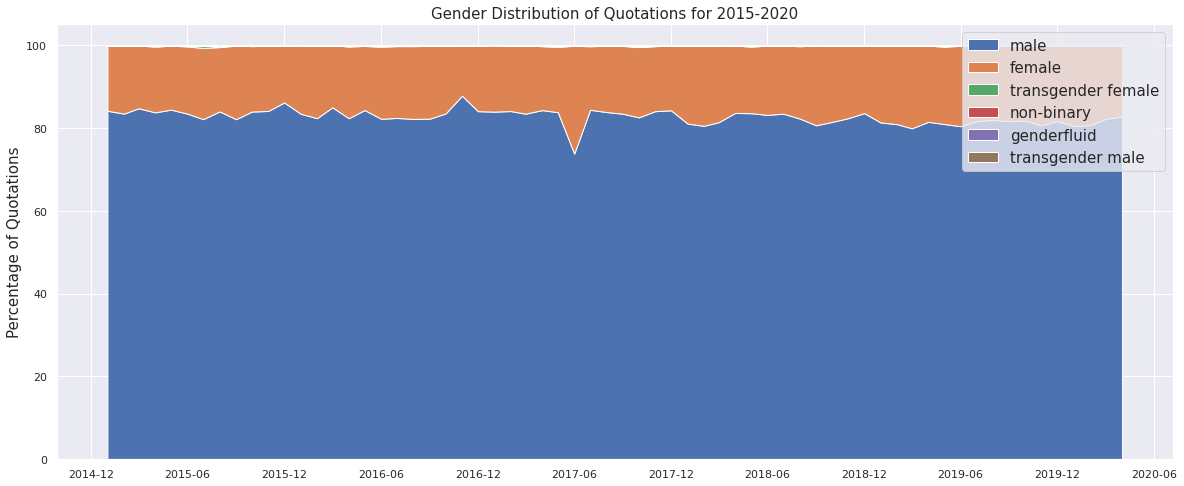

In [114]:
sns.set_theme()

# Set xticks to dates

#Create list with all the months
from datetime import datetime
month_list = []
for year in range(2015,2021):
    for month in range(1,13):
        if year == 2020 and month == 5:
            break
        else:
            month_list.append(str(year) + "-" + str(month))
        

x_values = [datetime.strptime(d, "%Y-%m").date() for d in month_list]

# Plot Percentage
fig, ax = plt.subplots(figsize=(20,8))
y_list = [gender_percent[gender] for gender in gender_percent]
label_list = [gender for gender in gender_percent]
months_size = len(months)

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(locator)
ax.stackplot(x_values, y_list, labels = (label_list))


ax.set_ylabel('Percentage of Quotations', fontsize=15)
ax.set_title("Gender Distribution of Quotations for 2015-2020",fontsize=15)
ax.legend(fontsize=15)



As we can see in the plot above, the percentage of quotations from female speaker seems to be more or less constant. However, it is slightly increasing (15% in 2015 vs 17% in 2020). We can also see that genders other than female and male are highly underrepresented. Let's plot them below to take a closer look.

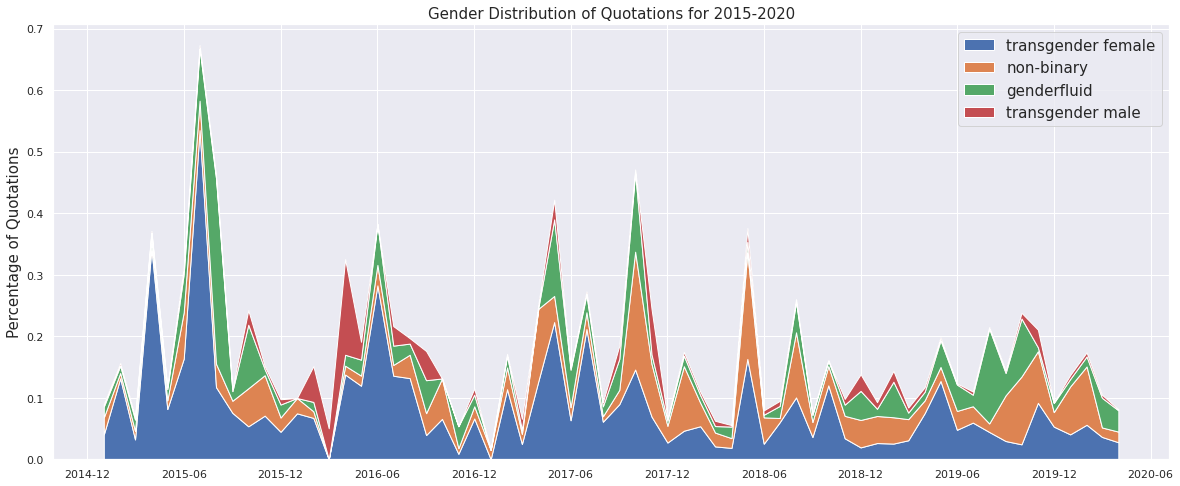

In [115]:
sns.set_theme()

# Set xticks to dates

#Create list with all the months
from datetime import datetime
month_list = []
for year in range(2015,2021):
    for month in range(1,13):
        if year == 2020 and month == 5:
            break
        else:
            month_list.append(str(year) + "-" + str(month))
        

x_values = [datetime.strptime(d, "%Y-%m").date() for d in month_list]

# Plot Percentage
fig, ax = plt.subplots(figsize=(20,8))
y_list = [gender_percent[gender] for gender in gender_percent if gender!='male' and gender!='female']
label_list = [gender for gender in gender_percent if gender!='male' and gender!='female']
months_size = len(months)

formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(locator)
ax.stackplot(x_values, y_list, labels = (label_list))


ax.set_ylabel('Percentage of Quotations', fontsize=15)
ax.set_title("Gender Distribution of Quotations for 2015-2020",fontsize=15)
ax.legend(fontsize=15)



This plot seems a bit more interesting. It would be a good idea to analyse the origin of each peak. For example, Caitlyn Jenner came out as a trans woman in around June 2015, when we see the biggest spike.

## Sentiment Analysis

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

To see how nltk's pretrained SentimentIntensityAnalyzer works and how we can interpret the results, we run this model only on the first 100000 rows of our pre-processed sample set. Although SentimentIntensityAnalyzer returns 4 seperate sentiment scores corresponding to negativity, neutrality, positivity and a combined score, we have decided only to use the combined score. By applying our own threshold on the combined score we are able to divide quotes into negative, positive and neutral categories by our own definition and investigate the result for different threshold definitions.

In [27]:
prep_pq_sent=prep_pq[:100000]
prep_pq_sent['sentiment_score']=[sia.polarity_scores(i)['compound'] for i in prep_pq_sent['quotation']]

C:\Users\medya\AppData\Local\Temp/ipykernel_15092/356047371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_pq_sent['sentiment_score']=[sia.polarity_scores(i)['compound'] for i in prep_pq_sent['quotation']]


Here as an initial trial sentiment thresholds are selected to be -0.4 and 0.4, but for Milestone3 the model will be run on the whole dataset and the final thresholds will be defined accordingly. 

In [28]:
for gender in ['male', 'female']:
    p_pos=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score']>0.4)]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    p_neg=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score']<-0.4)]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    p_ntr=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score'].between(-0.4, 0.4))]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    s_mean=prep_pq_sent[(prep_pq_sent['gender']==gender)]['sentiment_score'].mean()
    print('Average sentiment score for {g}s is: {s:.4f}'.format(g=gender, s=s_mean))
    print('Percentage of {g}s with positive quotes: {p:.2f}'.format(g=gender, p=100*p_pos))
    print('Percentage of {g}s with negative quotes: {p:.2f}'.format(g=gender, p=100*p_neg))
    print('Percentage of {g}s with neutral quotes: {p:.2f}'.format(g=gender, p=100*p_ntr))

Average sentiment score for males is: 0.1883
Percentage of males with positive quotes: 37.72
Percentage of males with negative quotes: 12.66
Percentage of males with neutral quotes: 49.62
Average sentiment score for females is: 0.1926
Percentage of females with positive quotes: 38.64
Percentage of females with negative quotes: 13.00
Percentage of females with neutral quotes: 48.36


From this tiny trial's results it looks like percentage of neutral quotes from males is higher than that of the females, whereas it is the opposite case for the positive and negative quotes. In Milestone3 we will be repeating this analysis for the whole dataset to make a conclusion and investigate the change in these scores with time.

## Thematic Analysis

For this initial analysis, we will only use the sample generated.

Furthermore, for a proper analysis it would be necessary to optimize the hyperparameter `num_topics`. For now we will simply assume `num_topics = 10`, which should give us a good enough place to start but for Phase 3 we will run a GridSearch to determine the optimal value.

Let's start by extracting the tokens for 'male' and 'female' and separate them.

In [4]:
from src.thematic_processing import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
tokens_male = prep_pq['tokens'][prep_pq['gender']=='male'].tolist()
tokens_female = prep_pq['tokens'][prep_pq['gender']=='female'].tolist()

In [6]:
# the algorithm used for LDA takes an iterable of strings, so we need to join all the tokens per quote
tokens_male = [' '.join(tokens) for tokens in tokens_male]
tokens_female = [' '.join(tokens) for tokens in tokens_female]

Now that we have the tokens ready, let's train our LDA model.

MALE RESULTS
0.8480727120858502
0.8480727120858502
0.8480727120858502
0.8480727120858502
0.7715417313451715
0.7707229382783514
0.7708754017620587
0.7697838375516377
0.7376457426079677
0.7442981528986834
0.7279471944690596
0.7284398263921337
0.7134122902786943
0.7140546599503115
0.7173080280965511
0.7178478130720427
0.7091065382201218
0.7053085652655671
0.7015663190784878
0.7102740461937586
0.7081747219008909
0.7037692095099641
0.7081003877866441
0.7058225700340351
Best coherence from cross-validation is 0.8480727120858502 for 1 topics and a document-topic prior distribution of 1.
Best Model's Params:  1 0.7
Coherence for full data:  0.8173004806027423


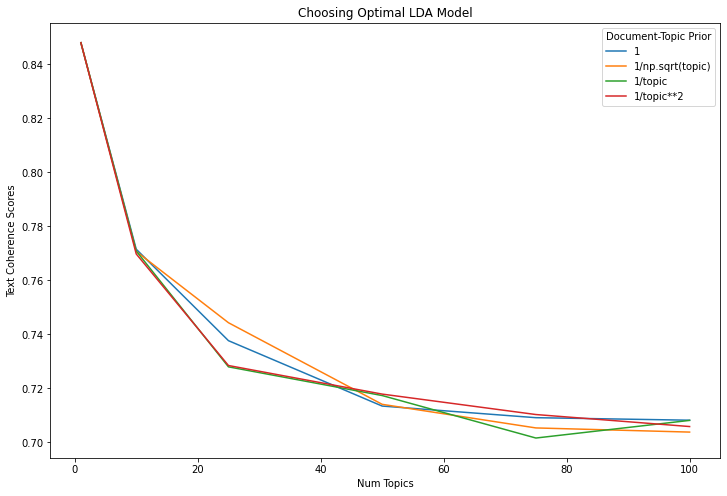


FEMALE RESULTS
0.7862192032697526
0.7862192032697526
0.7862192032697526
0.7862192032697526


KeyboardInterrupt: 

In [7]:
# DON'T TOUCH THIS!!
"""
start = timeit.default_timer()
num_topics = [1, 10, 25, 50, 75, 100]
learning_decays = ['1', '1/np.sqrt(topic)', '1/topic', '1/topic**2']

print('MALE RESULTS')
m_vectorizer, m_docword_matrix, m_best_lda_model = grid_search(tokens_male[:100000]  , num_topics, learning_decays, print_res = True, plot_res = True)

print('\nFEMALE RESULTS')
f_vectorizer, f_docword_matrix, f_best_lda_model = grid_search(tokens_female[:100000], num_topics, learning_decays, print_res = True, plot_res = True)

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')
"""

MALE RESULTS
50000
35082
-19.62806203936755
-19.62806203936755
-19.62806203936755
-19.62806203936755
-19.254725229725388
-19.452044622561736
-19.538905766794656
-19.38711410800294
-19.316902960600743
-19.449238730611818
-19.58797360550235
-19.52616993046643
-19.301329439163922
-19.54025722463288
-19.396909312462256
-19.500855218244737
-19.42451822276152
-19.511210982742746
-19.400764536950067
-19.3956527411016
-19.483947668035235
-19.52640007930271
-19.445845137021827
-19.52846133892778
Best coherence from cross-validation is -19.254725229725388 for 10 topics and a document-topic prior distribution of 1.
Best Model's Params:  10 0.7
Coherence for full data:  -18.97767276032292


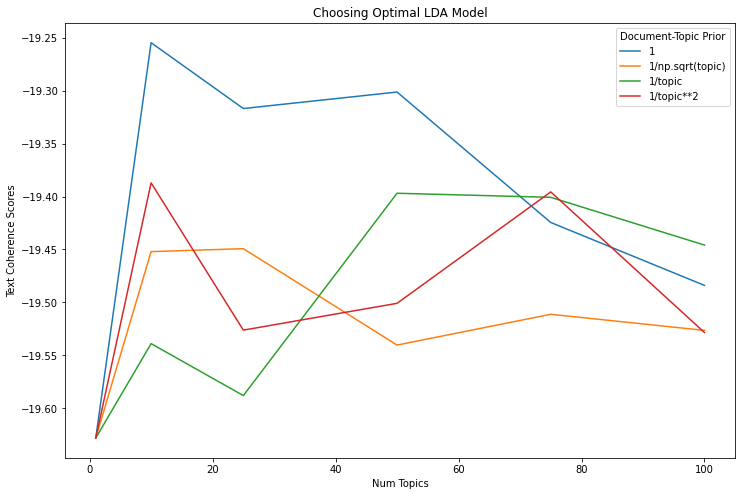


FEMALE RESULTS
50000
34361
-19.893225619764202
-19.893225619764202
-19.893225619764202
-19.893225619764202
-19.4176918798779
-19.578372042501325
-19.7359653228674
-19.594507273773964
-19.53526379846179
-19.522445531691403
-19.426882708253032
-19.620182331683658
-19.51311742289505
-19.634807191392355
-19.464636291183037
-19.46907658603736
-19.557310058687055
-19.501427141463694
-19.588508379690197
-19.406638269136877
-19.594213928294362
-19.47575387731549
-19.55389263350978
-19.540586418662933
Best coherence from cross-validation is -19.406638269136877 for 75 topics and a document-topic prior distribution of 1/topic**2.
Best Model's Params:  75 0.7
Coherence for full data:  -18.84743728634756


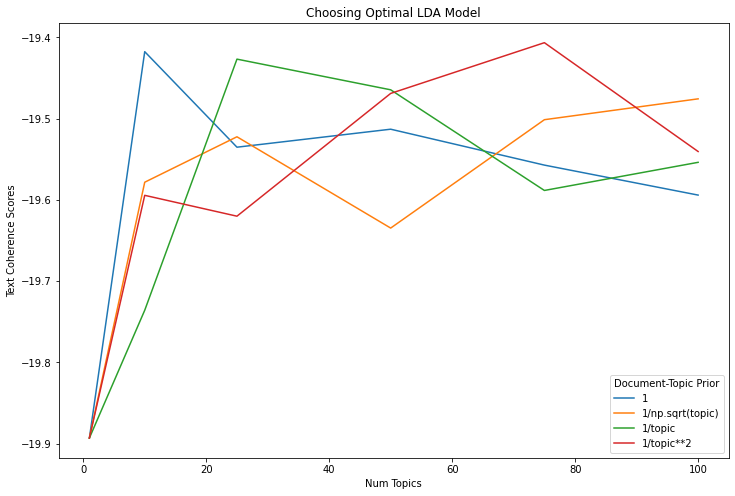

Time: 40893.0s


In [11]:
start = timeit.default_timer()
num_topics = [1, 10, 25, 50, 75, 100]
learning_decays = ['1', '1/np.sqrt(topic)', '1/topic', '1/topic**2']

print('MALE RESULTS')
m_vectorizer, m_docword_matrix, m_best_lda_model = grid_search(tokens_male[:50000]  , num_topics, learning_decays, print_res = True, plot_res = True, coh_method = 'u_mass')

print('\nFEMALE RESULTS')
f_vectorizer, f_docword_matrix, f_best_lda_model = grid_search(tokens_female[:50000], num_topics, learning_decays, print_res = True, plot_res = True, coh_method = 'u_mass')

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

MALE RESULTS
50000
35082
-19.40142803575426
-19.45761186013791
-19.37546659037642
-19.254725229725388
-19.63846048882533
-19.538905766794656
-19.6675626932881
-19.468088663220087
-19.602215416916536
-19.50804612569612
-19.56622550184872
-19.35185109823623
-19.470911062338697
-19.424525022828877
-19.531466130238606
-19.43303880332308
-19.4620602492957
-19.742356725315908
Best coherence from cross-validation is -19.254725229725388 for 10 topics and a document-topic prior distribution of 1.
Best Model's Params:  10 0.7
Coherence for full data:  -18.97767276032292


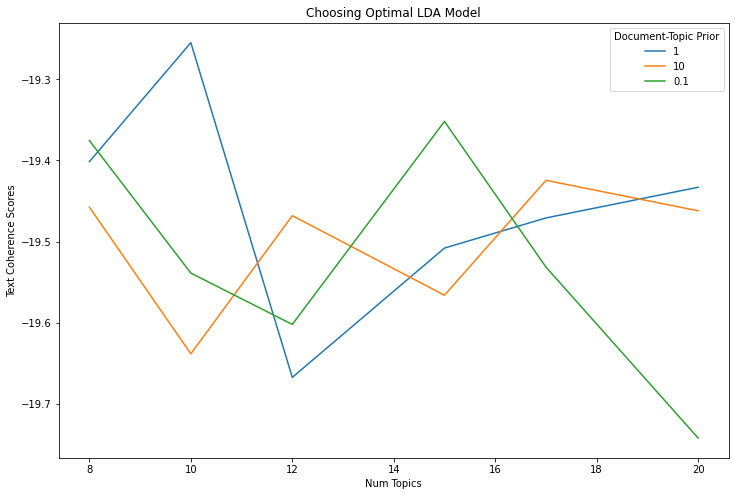


FEMALE RESULTS
50000
34361
-19.48386762830541
-19.61924194145886
-19.64227242228616
-19.4176918798779
-19.69286403340233
-19.7359653228674
-19.466742828665375
-19.7178545303141
-19.289687399508935
-19.554864969711858
-19.509011048687317
-19.442649402212865
-19.551956978098403
-19.531411453606957
-19.54034562148952
-19.586063904871985
-19.538099882981854
-19.333571059718743
Best coherence from cross-validation is -19.289687399508935 for 12 topics and a document-topic prior distribution of 0.1.
Best Model's Params:  12 0.7
Coherence for full data:  -18.709793431410883


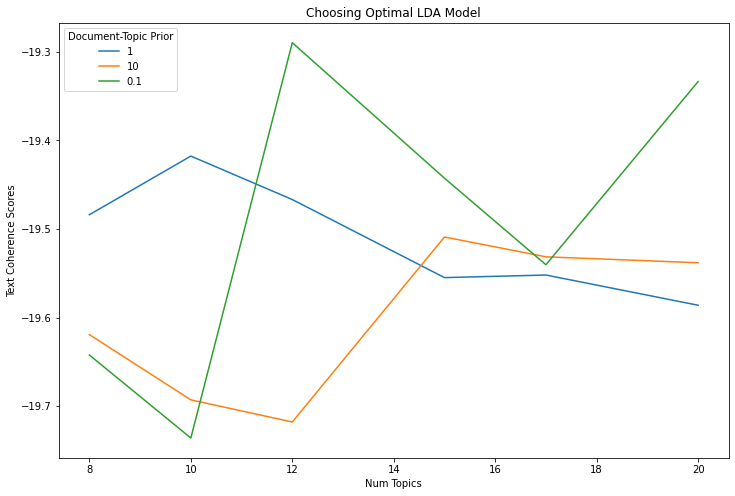

Time: 10333.3s


In [15]:
# now finally, for a fine grid search
start = timeit.default_timer()
num_topics = [8, 10, 12, 15, 17, 20]
learning_decays = ['1', '10', '0.1']

print('MALE RESULTS')
m_vectorizer, m_docword_matrix, m_best_lda_model = grid_search(tokens_male[:50000]  , num_topics, learning_decays, print_res = True, plot_res = True, coh_method = 'u_mass')

print('\nFEMALE RESULTS')
f_vectorizer, f_docword_matrix, f_best_lda_model = grid_search(tokens_female[:50000], num_topics, learning_decays, print_res = True, plot_res = True, coh_method = 'u_mass')

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Now we can see the topic distribution along our documents.

In [16]:
print('MALE TOPIC DISTRIBUTION')
m_df_document_topic, m_df_topic_distribution = topics_docs_matrix(m_best_lda_model, m_docword_matrix, show_dist = True)
print('FEMALE TOPIC DISTRIBUTION')
f_df_document_topic, f_df_topic_distribution = topics_docs_matrix(f_best_lda_model, f_docword_matrix, show_dist = True)

MALE TOPIC DISTRIBUTION


,Topic Num,Num Documents
0,6,6535
1,7,5433
2,5,3901
3,0,3766
4,3,3101
5,1,2920
6,4,2619
7,2,2511
8,9,2188
9,8,2108


FEMALE TOPIC DISTRIBUTION


,Topic Num,Num Documents
0,3,7797
1,4,4787
2,10,4115
3,0,4070
4,1,2160
5,7,1954
6,11,1854
7,2,1713
8,6,1661
9,5,1635


And see the intertopic distance, to visually gauge the correctness of the clustering.

*NOTE*: See files `LDA_Male.html` and `LDA_Female.html`

In [17]:
show_intertopic_distance(m_best_lda_model, m_docword_matrix, m_vectorizer, output_name = 'LDA_Male.html')
show_intertopic_distance(f_best_lda_model, f_docword_matrix, f_vectorizer, output_name = 'LDA_Female.html')

C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


And finally we can see the top words per topic and how the words are distributed in general.

In [18]:
print('DISTRIBUTION OF WORDS IN MALES')
m_df_topic_keywords = get_topics_words(m_best_lda_model, m_vectorizer, show_words = True)
print('MAIN WORDS PER TOPIC IN MALES')
m_df_top_words = get_top_words_per_topic(m_best_lda_model, m_vectorizer, n_words = 20)
display(m_df_top_words)

print('\nDISTRIBUTION OF WORDS IN FEMALES')
f_df_topic_keywords = get_topics_words(f_best_lda_model, f_vectorizer, show_words = True)
print('MAIN WORDS PER TOPIC IN FEMALES')
f_df_top_words = get_top_words_per_topic(f_best_lda_model, f_vectorizer, n_words = 20)
display(f_df_top_words)

DISTRIBUTION OF WORDS IN MALES


,abandon,abide,ability,able,abortion,abroad,absence,absolute,absolutely,absorb,...,yellow,yesterday,yield,yorker,young,youngster,youth,youtube,zone,zoom
Topic0,0.100122,0.100068,134.606049,131.936842,0.100037,0.100148,0.100335,0.104646,23.653299,0.100088,...,0.246087,107.222270,0.100232,0.100133,11.067735,0.100295,0.103900,0.100061,72.540912,0.100316
Topic1,1.324638,0.100440,1.125706,7.058655,0.100102,24.586790,0.100046,0.116883,1.728748,0.100086,...,0.100046,0.156949,0.100047,0.100138,2.648446,0.100092,1.098258,0.100033,0.244205,0.100087
Topic2,0.401979,0.102453,4.777504,530.487803,0.100420,0.100525,0.108039,0.143083,0.439420,0.100942,...,0.100318,8.903100,0.102936,18.945217,4.322322,0.100030,0.108574,0.100075,1.765817,0.101777
Topic3,0.100446,0.100202,13.347161,24.003081,0.100918,0.243066,0.100381,3.991737,25.524750,0.100106,...,0.100620,0.150617,0.100086,0.100096,127.870223,0.100098,75.339792,0.100391,0.164769,0.100681
Topic4,0.100113,0.100033,39.036394,11.109235,0.100027,0.101634,0.104640,36.046271,46.283480,15.230717,...,0.172735,0.451961,0.100527,0.100229,6.553228,0.100167,0.116150,0.100110,0.116511,0.100039
Topic5,21.570344,0.100098,6.695544,1.460190,0.100077,3.815805,0.100169,4.524860,58.202559,0.100829,...,0.105369,1.479690,0.100046,0.100895,1.586692,0.100068,0.128091,15.938968,0.117351,0.100030
Topic6,0.100053,0.100025,2.002574,31.752794,0.100020,0.100046,0.100085,1.001661,1.849800,0.100036,...,0.100277,0.112979,0.100044,0.100082,284.343292,13.565543,0.113647,0.100234,0.881516,0.100133
Topic7,1.222963,0.100121,28.863821,7.708670,0.105168,0.100170,21.800302,0.153723,0.219243,0.104936,...,0.100055,0.438084,29.715877,0.100068,0.107313,0.100020,3.126071,0.100134,0.100951,0.100028
Topic8,0.135641,19.386966,42.447326,22.102879,20.546628,0.101756,0.100303,0.455470,13.701819,0.100268,...,0.100208,0.937313,0.251054,0.100062,8.857014,0.100272,0.306311,0.100035,7.139092,0.100049
Topic9,0.100268,0.100161,3.775263,108.231109,0.100866,0.112540,0.569891,0.143482,7.224216,0.100353,...,15.232644,0.713528,1.140808,0.100061,0.619378,0.103066,0.134374,0.110751,0.765215,13.767284


MAIN WORDS PER TOPIC IN MALES


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,think,lot,right,game,know,thing,point,player,end,mean,little,lose,obviously,chance,tell,come,away,definitely,win,goal
Topic 1,work,community,make,support,health,care,important,understand,decision,local,protect,public,meet,process,staff,worker,thing,group,continue,policy
Topic 2,day,today,week,month,able,school,let,leave,year,stay,deal,area,thank,early,virus,make,base,small,home,close
Topic 3,people,want,world,make,life,bring,live,new,experience,city,person,create,student,grow,club,future,story,idea,share,music
Topic 4,time,good,look,way,year,come,forward,level,help,challenge,face,step,learn,difficult,expect,high,strong,certainly,remain,long
Topic 5,family,state,government,use,issue,ask,member,party,law,hold,problem,power,political,country,clear,force,question,information,police,stop
Topic 6,play,really,say,feel,know,team,guy,start,happen,big,love,thing,come,try,year,good,want,kind,season,bit
Topic 7,provide,impact,covid,business,test,increase,number,social,spread,case,include,market,service,growth,economic,industry,coronavirus,continue,ensure,large
Topic 8,need,place,country,opportunity,make,possible,child,change,drive,plan,improve,hospital,nation,safety,line,bad,woman,prepare,entire,program
Topic 9,different,new,set,actually,great,offer,food,road,walk,raise,buy,form,try,company,price,body,high,fast,year,change



DISTRIBUTION OF WORDS IN FEMALES


,abandon,abide,ability,able,abolish,aboriginal,abortion,abroad,absence,absolute,...,yoga,yorker,yorkshire,young,youngster,youth,youtube,zealander,zone,zoom
Topic0,0.083335,0.083335,63.568530,385.651235,0.083335,0.083336,0.083336,0.083340,0.083342,0.083338,...,0.083338,0.083338,0.083339,82.810991,0.083338,0.083342,0.083337,0.083362,0.083343,0.083338
Topic1,0.083336,0.083347,64.086598,0.083515,0.083336,0.083339,0.083340,0.083340,0.083337,0.083443,...,0.083337,0.083337,0.083349,0.083369,0.083341,0.597759,15.954863,23.365068,33.584962,0.083337
Topic2,0.083356,0.083340,0.083344,17.922824,0.083335,0.083347,0.083339,0.083341,0.083339,0.083338,...,0.083338,0.083336,11.582840,0.087640,0.083338,0.083344,0.083339,0.083336,0.083337,0.083346
Topic3,0.083336,0.083341,0.083340,172.195370,0.083336,0.083336,0.083336,0.083336,0.083338,0.083350,...,0.083338,0.083337,0.083343,162.193455,0.083337,0.083341,0.083353,0.083336,0.083355,0.083340
Topic4,0.083384,0.083369,0.088300,98.797004,0.083336,0.083338,0.083338,35.152947,0.083336,44.040715,...,40.209466,0.083336,0.083338,247.584376,0.083340,32.096741,0.085086,0.083337,6.769149,0.083970
Topic5,28.577399,22.176612,0.083345,0.083343,0.083345,0.083336,0.083342,0.083344,26.910839,0.083404,...,0.083337,0.083335,0.083339,31.516574,0.083337,0.083338,0.084120,0.083337,0.083336,0.083336
Topic6,0.083341,0.083344,58.063987,40.089238,0.083338,0.083348,0.083340,0.083341,0.083337,0.083338,...,0.083338,13.772818,0.083338,0.083662,10.953174,62.707643,0.083341,0.083340,0.095703,0.083336
Topic7,0.083339,0.083363,0.083357,0.083364,0.083340,11.789986,0.083338,0.083339,0.083336,0.083339,...,0.083337,0.083339,0.083338,0.083344,0.083336,1.895778,0.083342,0.083337,0.083338,0.083341
Topic8,0.083337,0.083337,0.083339,74.283992,8.881998,0.083337,86.211072,0.083341,0.083336,7.334658,...,0.083351,0.083405,0.083355,0.083339,0.083341,0.083338,0.083357,0.083338,0.083337,12.293418
Topic9,0.083336,0.085233,0.083339,24.958885,0.083337,0.083336,0.083340,0.083338,0.083350,2.467443,...,0.083338,0.083336,0.083339,3.343061,0.083336,0.083342,4.800112,0.083353,0.083337,0.083337


MAIN WORDS PER TOPIC IN FEMALES


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,make,play,sure,team,really,good,opportunity,work,game,think,year,want,great,big,decision,able,come,new,way,learn
Topic 1,community,people,help,support,need,health,family,care,way,work,question,forward,look,american,music,great,matter,possible,new,protect
Topic 2,believe,right,party,power,country,president,leave,people,say,campaign,fight,stand,minute,lie,actor,clear,abuse,role,water,time
Topic 3,think,people,know,really,say,want,thing,feel,lot,tell,time,make,try,happen,come,talk,way,love,story,good
Topic 4,time,year,day,love,woman,family,work,life,make,girl,come,friend,thank,kid,look,long,child,happy,old,week
Topic 5,social,home,people,stay,need,remain,medium,force,view,control,policy,require,staff,financial,child,imagine,order,practice,make,law
Topic 6,political,market,change,level,high,new,climate,risk,violence,expect,return,project,demand,free,reality,produce,low,global,job,deal
Topic 7,use,company,need,increase,number,patient,business,people,food,enjoy,product,hospital,work,test,rate,information,consider,provide,make,new
Topic 8,plan,business,hand,time,safe,fall,chance,future,offer,support,sit,worker,fund,art,need,piece,place,artist,candidate,people
Topic 9,money,look,point,make,use,space,wear,tough,day,raise,picture,away,night,hair,phone,sound,private,big,head,huge


With all of these results it is clear that a division of the quotes by topics is definitely possible (although, since we haven't optimized the number of topics yet, it does seem that some of them aren't very specific). Through manual labeling we can state that the main topics for men are : sports (Topic9 + Topic0 : 'play', 'team', 'win', 'player', 'game') and relationships (Topic1 : 'family', 'friends', 'love', 'home', 'community') while for women are : relationships (Topic2 : 'love', 'life', 'friend', 'family') and work (Topic5 : 'work', 'support', 'help', 'opportunity', 'build').

From the files `LDA_Male.html` and `LDA_Female.html` it is clear the division is adequate, as we have several large, non-overlapping clusters.

Note on Text Readability / Complexity: In Milestone3 we will create another version of tokens without dropping the stopwords and by using these tokens we will apply the Dale-Chall Readability Formula to measure the difficulty/complexity levels of the quotations.